In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor

# x_option = 'anomaly_ak135'
# # x_option = 'anomaly'
# y_option = 'anomaly_isc'
# df = pd.read_csv('updeANMO_shift5_catalog_2010_stnflt_plot_p_ak135.csv')
# df_xcorr = (df[y_option]>0) & (abs(df[x_option])<15) & (df['probability']>0.8)
# df.loc[df_xcorr,y_option] = df.loc[df_xcorr,y_option] - df.loc[df_xcorr,'calctim_ak135']
# # df_xcorr['anomaly_isc'] = df_xcorr['anomaly_isc'] - df_xcorr['calctim_ak135']
# # df_xcorr
# x = df.loc[df_xcorr,x_option].values
# # x = df.loc[df_xcorr,'anomaly_ak135'].values
# y = df.loc[df_xcorr,y_option].values; y_label = y_option
# # y = df.loc[df_xcorr,'anomaly_isc'].values - x; y_label = 'anomaly_isc - x'

# phase = 's'
# x_option = 'travel_time_residue_ml_fit_isc'
# y_option = 'travel_time_residue_isc'
# x_option = 'travel_time_residue_isc'
# y_option = 'travel_time_residue_ml_fit_isc'
# x_option = 'anomaly'
plt.rcParams["font.size"] = 16
plt.figure(figsize=(8,6))
def plot_slope(phase, x_option, y_option, substract_coef, year='*', max_anomaly_abs=15, min_probability=0.7, min_snr=0, demean=True, average_ray=True, regression='theilsen', mark_size=lambda r: 10*r**2, swap_xy=False):
    df = pd.concat([pd.read_csv(filename) for filename in glob.glob(f'updeANMO_shift5_catalog_{year}_stnflt_isc_plot_{phase}.csv')], ignore_index=True)
    xcorr = lambda df: (abs(df[f'{phase.lower()}_travel_residue_ml_fit_isc'])<max_anomaly_abs) & (df[f'{phase.lower()}_probability_ml']>min_probability) & (df[f'{phase.lower()}_snr_ml']>min_snr)
    slope_table = df[xcorr(df)]
    if average_ray:
        count_org = len(slope_table)
        # print(f"Before: {count_org}")
        std = np.std(slope_table[x_option].values[:])
        for idx, rec in slope_table.iterrows():
            half_length = 2
            while (True):
                neighbor_value = slope_table.loc[(slope_table['turning_lon']<rec['turning_lon']+half_length) & (slope_table['turning_lon']>rec['turning_lon']-half_length) & (slope_table['turning_lat']<rec['turning_lat']+half_length) & (slope_table['turning_lat']>rec['turning_lat']-half_length), x_option]
                # print(len(neighbor_value))
                if len(neighbor_value) > 20: half_length /= 1.5
                else: break
            if len(neighbor_value) > 3:
                if (rec[x_option] > np.mean(neighbor_value) + std) or (rec[x_option] < np.mean(neighbor_value) - std):
                    # print(rec.name, idx)
                    df.loc[idx, f'{phase.lower()}_probability_ml'] = 0
        slope_table = df[xcorr(df)]
        print(f"{count_org-len(slope_table)} outliers are removed")
        # print(f"After: len(scatter_table)")
    if swap_xy: x_option, y_option = y_option, x_option
    x = slope_table[x_option].values
    y = slope_table[y_option].values - substract_coef*x
    prob = slope_table[f'{phase.lower()}_probability_ml'].values
    y_label = f'{y_option} - x / {round(1/substract_coef, 2)}' if substract_coef else y_option

    if demean: 
        x = x - np.mean(x)
        y = y - np.mean(y)

    plt.scatter(x, y, s=mark_size(prob), marker='o')

    if regression == 'linear':
        b, a = np.polyfit(x, y, deg=1)
        xseq = np.linspace(min(x), max(x), num=100)
        plt.plot(xseq, a + b * xseq, color="k", lw=3)

        xseq = np.linspace(min(x), 0, num=100)
        b, a = np.polyfit(x[x<=0], y[x<=0], deg=1)
        plt.plot(xseq, a + b * xseq, color="k", lw=3)
        xseq = np.linspace(0, max(x), num=100)
        b, a = np.polyfit(x[x>=0], y[x>=0], deg=1)
        plt.plot(xseq, a + b * xseq, color="k", lw=3)

    if regression == 'theilsen':
        # coef = [None, None]
        slope = [None, None]
        if swap_xy:
            y_fit_negative = np.array([min(y[y<=0]), max(y[y<=0])])
            y_fit_positive = np.array([min(y[y>=0]), max(y[y>=0])])
            theilsen = TheilSenRegressor(random_state=42).fit(y[y<=0].reshape(-1,1), x[y<=0])
            slope[0] = round(float(np.diff(y_fit_negative) / np.diff(theilsen.predict(y_fit_negative.reshape(-1,1)))), 4)
            plt.plot(theilsen.predict(y_fit_negative.reshape(-1,1)), y_fit_negative, color="k", lw=3)
            plt.plot(theilsen.predict(y_fit_positive.reshape(-1,1)), y_fit_positive, color="darkgray", lw=2)
            theilsen = TheilSenRegressor(random_state=42).fit(y[y>=0].reshape(-1,1), x[y>=0])
            slope[1] = round(float(np.diff(y_fit_positive) / np.diff(theilsen.predict(y_fit_positive.reshape(-1,1)))), 4)
            plt.plot(theilsen.predict(y_fit_positive.reshape(-1,1)), y_fit_positive, color="k", lw=3)

        else:
            x_fit_negative = np.array([min(x[x<=0]), max(x[x<=0])])
            x_fit_positive = np.array([min(x[x>=0]), max(x[x>=0])])
            theilsen = TheilSenRegressor(random_state=42).fit(x[x<=0].reshape(-1,1), y[x<=0])
            # coef[0] = theilsen.score(x[x<=0].reshape(-1,1), y[x<=0])
            slope[0] = round(float(np.diff(theilsen.predict(x_fit_negative.reshape(-1,1))) / np.diff(x_fit_negative)), 4)
            plt.plot(x_fit_negative, theilsen.predict(x_fit_negative.reshape(-1,1)), color="k", lw=3)
            plt.plot(x_fit_positive, theilsen.predict(x_fit_positive.reshape(-1,1)), color="darkgray", lw=2)
            theilsen = TheilSenRegressor(random_state=42).fit(x[x>=0].reshape(-1,1), y[x>=0])
            # coef[1] = theilsen.score(x[x>=0].reshape(-1,1), y[x>=0])
            slope[1] = round(float(np.diff(theilsen.predict(x_fit_positive.reshape(-1,1))) / np.diff(x_fit_positive)), 4)
            plt.plot(x_fit_positive, theilsen.predict(x_fit_positive.reshape(-1,1)), color="k", lw=3)

    plt.xlabel(x_option)
    plt.ylabel(y_label)
    plt.title(f'{phase.upper()} travel time residuals (sec), {len(x)} pts\nratio = {tuple(slope)}')
    return slope_table

<Figure size 576x432 with 0 Axes>

In [11]:
#to compare hsml
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor


plt.rcParams["font.size"] = 16
plt.figure(figsize=(8,6))
def plot_slope(phase, x_option, y_option, substract_coef, year='*', max_anomaly_abs=15, min_probability=0.7, min_snr=0, demean=True, average_ray=True, regression='theilsen', mark_size=lambda r: 10*r**2, swap_xy=False):
    df1 = pd.concat([pd.read_csv(filename) for filename in glob.glob(f'updeANMO_shift5_catalog_{year}_stnflt_isc_plot_{phase}.csv')], ignore_index=True)
    df2 = pd.concat([pd.read_csv(filename) for filename in glob.glob(f'hmsl_isc_plot_{phase}.csv')], ignore_index=True)
    df = pd.concat([df1, df2])
    xcorr = lambda df: (abs(df[f'{phase.lower()}_travel_residue_ml_fit_isc'])<max_anomaly_abs) & (df[f'{phase.lower()}_probability_ml']>min_probability) & (df[f'{phase.lower()}_snr_ml']>min_snr)
    slope_table = df[xcorr(df)]
    if average_ray:
        count_org = len(slope_table)
        # print(f"Before: {count_org}")
        std = np.std(slope_table[x_option].values[:])
        for idx, rec in slope_table.iterrows():
            half_length = 2
            while (True):
                neighbor_value = slope_table.loc[(slope_table['turning_lon']<rec['turning_lon']+half_length) & (slope_table['turning_lon']>rec['turning_lon']-half_length) & (slope_table['turning_lat']<rec['turning_lat']+half_length) & (slope_table['turning_lat']>rec['turning_lat']-half_length), x_option]
                # print(len(neighbor_value))
                if len(neighbor_value) > 20: half_length /= 1.5
                else: break
            if len(neighbor_value) > 3:
                if (rec[x_option] > np.mean(neighbor_value) + std) or (rec[x_option] < np.mean(neighbor_value) - std):
                    # print(rec.name, idx)
                    df.loc[idx, f'{phase.lower()}_probability_ml'] = 0
        slope_table = df[xcorr(df)]
        print(f"{count_org-len(slope_table)} outliers are removed")
        # print(f"After: len(scatter_table)")
    if swap_xy: x_option, y_option = y_option, x_option
    x = slope_table[x_option].values
    y = slope_table[y_option].values - substract_coef*x
    prob = slope_table[f'{phase.lower()}_probability_ml'].values
    y_label = f'{y_option} - x / {round(1/substract_coef, 2)}' if substract_coef else y_option

    if demean: 
        x = x - np.mean(x)
        y = y - np.mean(y)

    plt.scatter(x, y, s=mark_size(prob), marker='o')

    if regression == 'linear':
        b, a = np.polyfit(x, y, deg=1)
        xseq = np.linspace(min(x), max(x), num=100)
        plt.plot(xseq, a + b * xseq, color="k", lw=3)

        xseq = np.linspace(min(x), 0, num=100)
        b, a = np.polyfit(x[x<=0], y[x<=0], deg=1)
        plt.plot(xseq, a + b * xseq, color="k", lw=3)
        xseq = np.linspace(0, max(x), num=100)
        b, a = np.polyfit(x[x>=0], y[x>=0], deg=1)
        plt.plot(xseq, a + b * xseq, color="k", lw=3)

    if regression == 'theilsen':
        # coef = [None, None]
        slope = [None, None]
        if swap_xy:
            y_fit_negative = np.array([min(y[y<=0]), max(y[y<=0])])
            y_fit_positive = np.array([min(y[y>=0]), max(y[y>=0])])
            theilsen = TheilSenRegressor(random_state=42).fit(y[y<=0].reshape(-1,1), x[y<=0])
            slope[0] = round(float(np.diff(y_fit_negative) / np.diff(theilsen.predict(y_fit_negative.reshape(-1,1)))), 4)
            plt.plot(theilsen.predict(y_fit_negative.reshape(-1,1)), y_fit_negative, color="k", lw=3)
            plt.plot(theilsen.predict(y_fit_positive.reshape(-1,1)), y_fit_positive, color="darkgray", lw=2)
            theilsen = TheilSenRegressor(random_state=42).fit(y[y>=0].reshape(-1,1), x[y>=0])
            slope[1] = round(float(np.diff(y_fit_positive) / np.diff(theilsen.predict(y_fit_positive.reshape(-1,1)))), 4)
            plt.plot(theilsen.predict(y_fit_positive.reshape(-1,1)), y_fit_positive, color="k", lw=3)

        else:
            x_fit_negative = np.array([min(x[x<=0]), max(x[x<=0])])
            x_fit_positive = np.array([min(x[x>=0]), max(x[x>=0])])
            theilsen = TheilSenRegressor(random_state=42).fit(x[x<=0].reshape(-1,1), y[x<=0])
            # coef[0] = theilsen.score(x[x<=0].reshape(-1,1), y[x<=0])
            slope[0]             = round(float(np.diff(theilsen.predict(x_fit_negative.reshape(-1,1))) / np.diff(x_fit_negative)), 4)
            plt.plot(x_fit_negative, theilsen.predict(x_fit_negative.reshape(-1,1)), color="k", lw=3)
            plt.plot(x_fit_positive, theilsen.predict(x_fit_positive.reshape(-1,1)), color="darkgray", lw=2)
            theilsen = TheilSenRegressor(random_state=42).fit(x[x>=0].reshape(-1,1), y[x>=0])
            # coef[1] = theilsen.score(x[x>=0].reshape(-1,1), y[x>=0])
            slope[1] = round(float(np.diff(theilsen.predict(x_fit_positive.reshape(-1,1))) / np.diff(x_fit_positive)), 4)
            plt.plot(x_fit_positive, theilsen.predict(x_fit_positive.reshape(-1,1)), color="k", lw=3)

    plt.xlabel(x_option)
    plt.ylabel(y_label)
    plt.title(f'{phase.upper()} travel time residuals (sec), {len(x)} pts\nratio = {tuple(slope)}')
    return slope_table

<Figure size 576x432 with 0 Axes>

0 outliers are removed


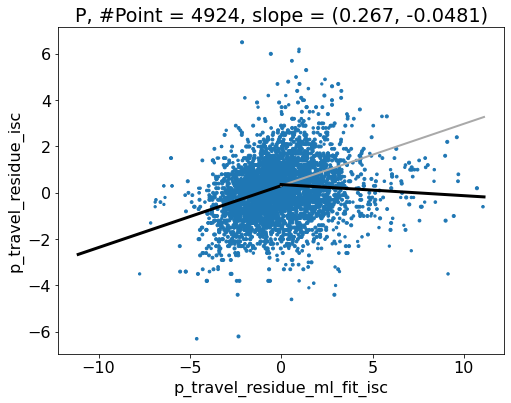

In [16]:
phase = 'p'
x_option = f'{phase.lower()}_travel_residue_ml_fit_isc'
y_option = f'{phase.lower()}_travel_residue_isc'
substract_coef = 0#1/3.5
plot_slope(phase, x_option, y_option, substract_coef, year='*', min_snr=40)

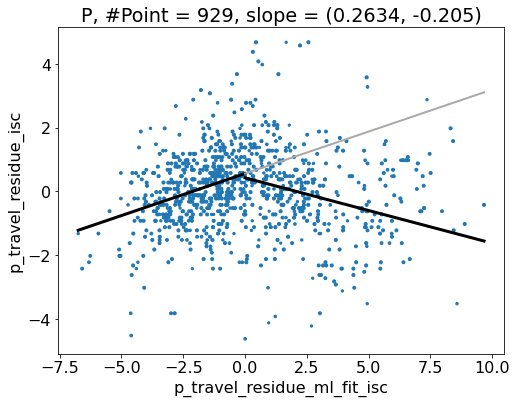

In [6]:
plot_slope(phase, x_option, y_option, substract_coef, year='2010', min_snr=40, average_ray=False)

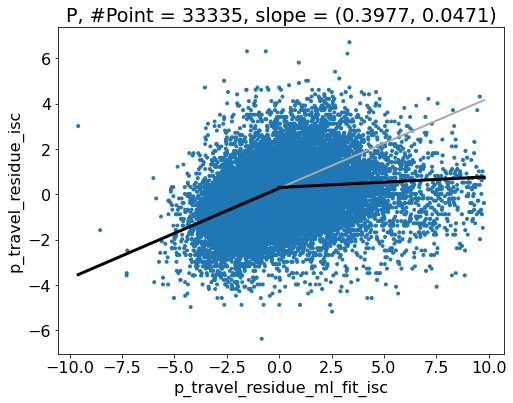

In [11]:
phase = 'p'
x_option = f'{phase}_travel_residue_ml_fit_isc'
y_option = f'{phase}_travel_residue_isc'
substract_coef = 0#1/3.5
_ = plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.9, year='*', min_snr=0, max_anomaly_abs=12, demean=True, average_ray=False)

5811 outliers are removed


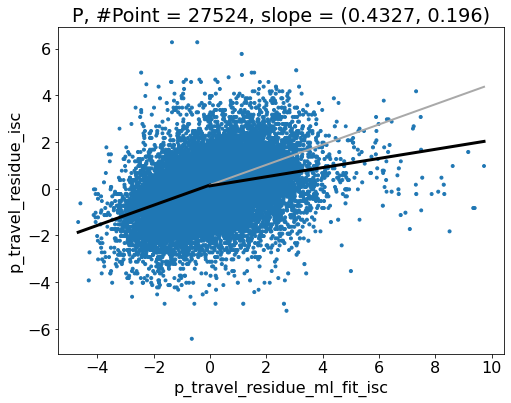

In [4]:
phase = 'p'
x_option = f'{phase}_travel_residue_ml_fit_isc'
y_option = f'{phase}_travel_residue_isc'
substract_coef = 0#1/3.5
tb = plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.9, year='*', min_snr=0, max_anomaly_abs=12, demean=True)

5567 outliers are removed
91 outliers are removed


<Figure size 432x288 with 0 Axes>

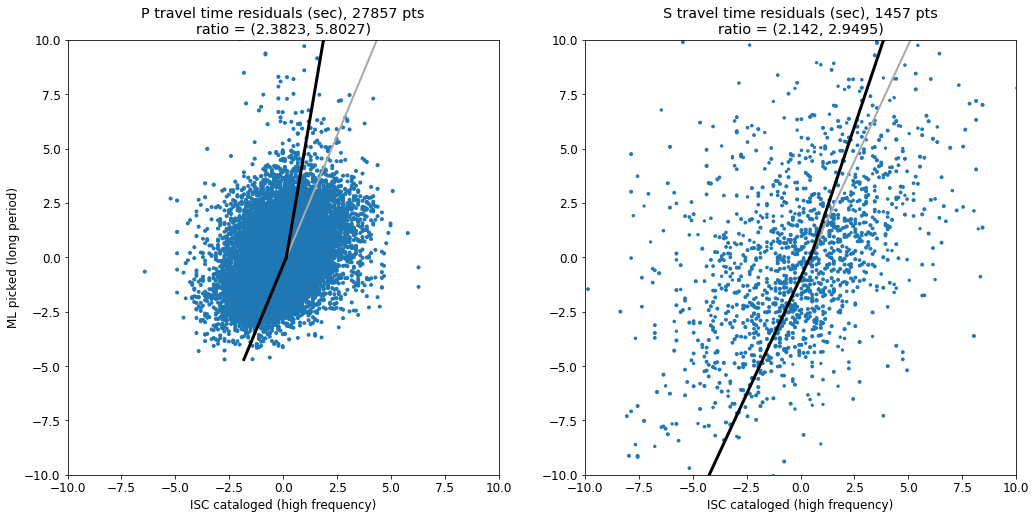

In [4]:
plt.cla(); plt.clf()
plt.rcParams["font.size"] = 12
plt.figure(figsize=(17,8))
phase = 'p'
x_option = f'{phase}_travel_residue_ml_fit_isc'
y_option = f'{phase}_travel_residue_isc'
substract_coef = 0#1/3.5
plt.subplot(121)
tb_p = plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.9, year='*', min_snr=0, max_anomaly_abs=15, demean=True, swap_xy=True)
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('ISC cataloged (high frequency)')
plt.ylabel('ML picked (long period)')

phase = 's'
x_option = f'{phase}_travel_residue_ml_fit_isc'
y_option = f'{phase}_travel_residue_isc'
plt.subplot(122)
tb_s = plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.7, year='*', min_snr=0, max_anomaly_abs=15, demean=True, swap_xy=True)
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('ISC cataloged (high frequency)')
plt.ylabel('')

plt.show()


<Figure size 432x288 with 0 Axes>

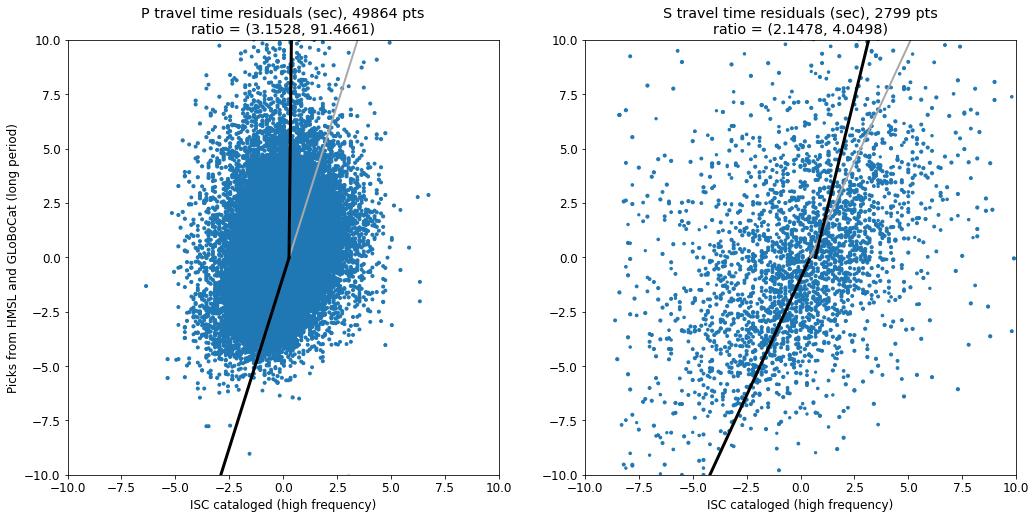

In [13]:
plt.cla(); plt.clf()
plt.rcParams["font.size"] = 12
plt.figure(figsize=(17,8))
phase = 'p'
x_option = f'{phase}_travel_residue_ml_fit_isc'
y_option = f'{phase}_travel_residue_isc'
substract_coef = 0#1/3.5
plt.subplot(121)
tb_p = plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.9, year='*', min_snr=0, max_anomaly_abs=15, demean=True, average_ray=False, swap_xy=True)
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('ISC cataloged (high frequency)')
# plt.ylabel('ML picked (long period)')
plt.ylabel('Picks from HMSL and GLoBoCat (long period)')

phase = 's'
x_option = f'{phase}_travel_residue_ml_fit_isc'
y_option = f'{phase}_travel_residue_isc'
plt.subplot(122)
tb_s = plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.7, year='*', min_snr=0, max_anomaly_abs=15, demean=True, average_ray=False, swap_xy=True)
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('ISC cataloged (high frequency)')
plt.ylabel('')

plt.show()

In [6]:
tb_p['p_travel_residue_ml_fit_isc'].describe()

count    33424.000000
mean         2.248837
std          1.993917
min         -7.376800
25%          0.994550
50%          1.996650
75%          3.156150
max         14.986300
Name: p_travel_residue_ml_fit_isc, dtype: float64

In [7]:
tb_s['s_travel_residue_ml_fit_isc'].describe()

count    1548.000000
mean        3.448340
std         3.927629
min       -10.137100
25%         0.823025
50%         3.347250
75%         5.945100
max        14.984600
Name: s_travel_residue_ml_fit_isc, dtype: float64

<Figure size 432x288 with 0 Axes>

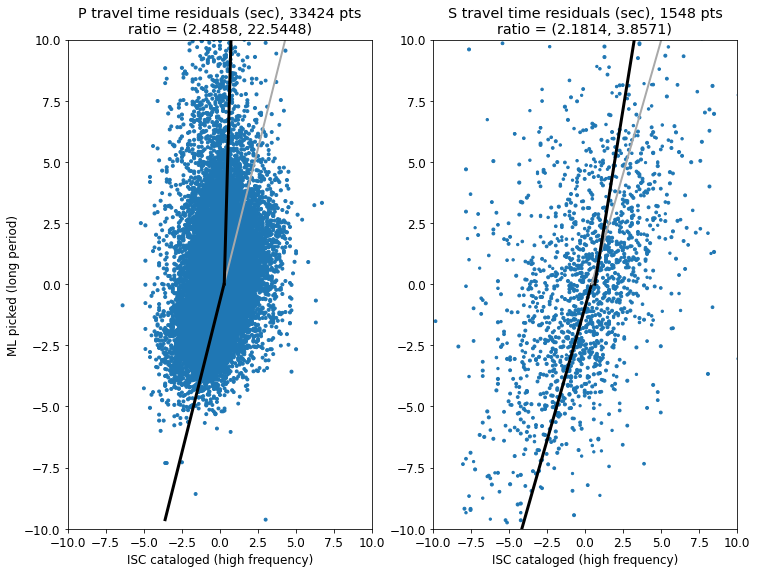

In [3]:
plt.cla(); plt.clf()
plt.rcParams["font.size"] = 12
plt.figure(figsize=(12,9))
phase = 'p'
x_option = f'{phase}_travel_residue_ml_fit_isc'
y_option = f'{phase}_travel_residue_isc'
substract_coef = 0#1/3.5
plt.subplot(121)
tb_p = plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.9, year='*', min_snr=0, max_anomaly_abs=15, demean=True, average_ray=False, swap_xy=True)
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('ISC cataloged (high frequency)')
plt.ylabel('ML picked (long period)')

phase = 's'
x_option = f'{phase}_travel_residue_ml_fit_isc'
y_option = f'{phase}_travel_residue_isc'
plt.subplot(122)
tb_s = plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.7, year='*', min_snr=0, max_anomaly_abs=15, demean=True, average_ray=False, swap_xy=True)
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('ISC cataloged (high frequency)')
plt.ylabel('')

plt.show()

3858 outliers are removed
46 outliers are removed


<Figure size 432x288 with 0 Axes>

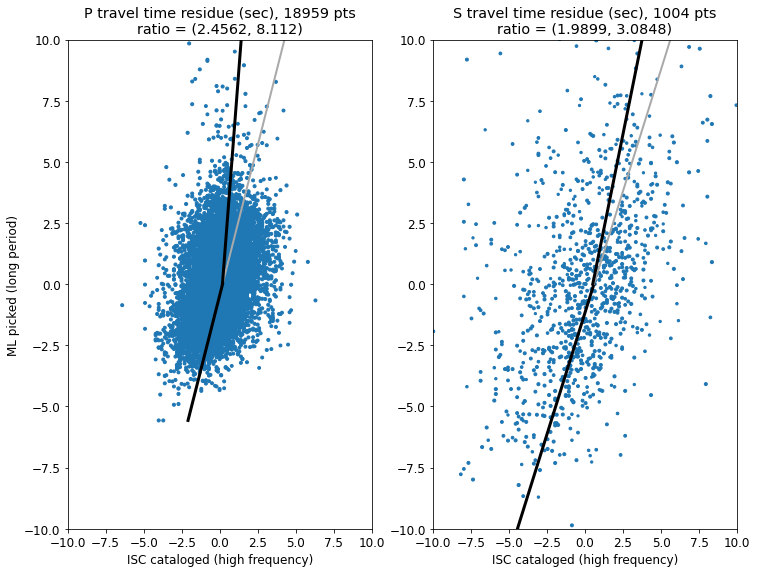

In [3]:
plt.cla(); plt.clf()
plt.rcParams["font.size"] = 12
plt.figure(figsize=(12,9))
phase = 'p'
x_option = f'{phase}_travel_residue_ml_fit_isc'
y_option = f'{phase}_travel_residue_isc'
substract_coef = 0#1/3.5
plt.subplot(121)
tb_p = plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.9, year='*', min_snr=15, max_anomaly_abs=15, demean=True, swap_xy=True)
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('ISC cataloged (high frequency)')
plt.ylabel('ML picked (long period)')

phase = 's'
x_option = f'{phase}_travel_residue_ml_fit_isc'
y_option = f'{phase}_travel_residue_isc'
plt.subplot(122)
tb_s = plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.7, year='*', min_snr=15, max_anomaly_abs=15, demean=True, swap_xy=True)
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('ISC cataloged (high frequency)')
plt.ylabel('')

plt.show()

5811 outliers are removed


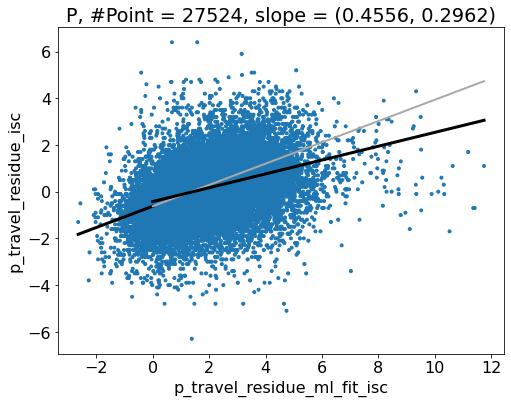

In [12]:
phase = 'p'
x_option = f'{phase}_travel_residue_ml_fit_isc'
y_option = f'{phase}_travel_residue_isc'
substract_coef = 0#1/3.5
tb = plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.9, year='*', min_snr=0, max_anomaly_abs=12, demean=False)

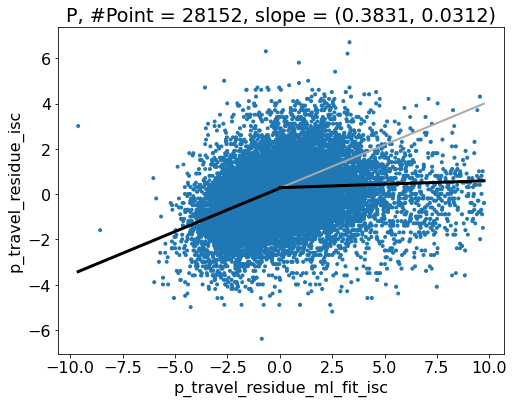

In [97]:
phase = 'p'
x_option = f'{phase}_travel_residue_ml_fit_isc'
y_option = f'{phase}_travel_residue_isc'
substract_coef = 0#1/3.5
plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.9, year='*', min_snr=0, max_anomaly_abs=12, demean=True)

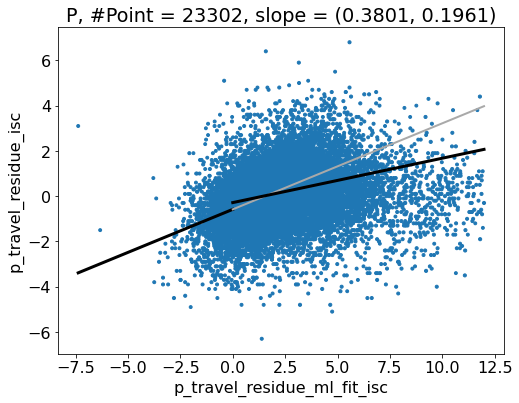

In [91]:
plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.9, year='*', min_snr=10, max_anomaly_abs=12, demean=False)

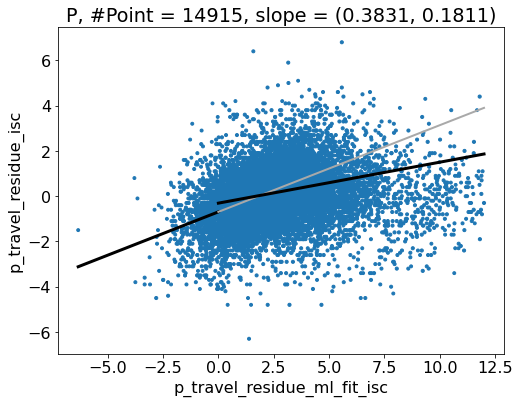

In [92]:
plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.9, year='*', min_snr=20, max_anomaly_abs=12, demean=False)

137 outliers are removed


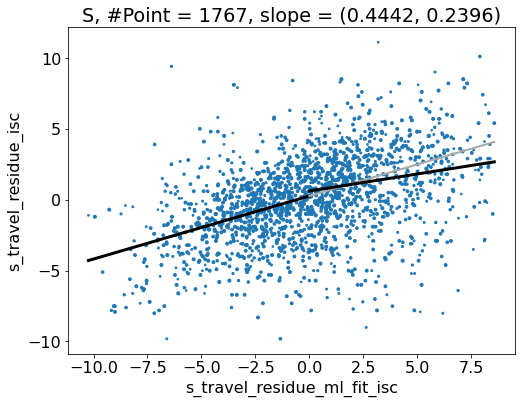

In [14]:
phase = 's'
x_option = f'{phase}_travel_residue_ml_fit_isc'
y_option = f'{phase}_travel_residue_isc'
substract_coef = 0#1/3.5
tb = plot_slope(phase, x_option, y_option, substract_coef, min_probability=0.5, year='*', min_snr=0, max_anomaly_abs=12, demean=True)

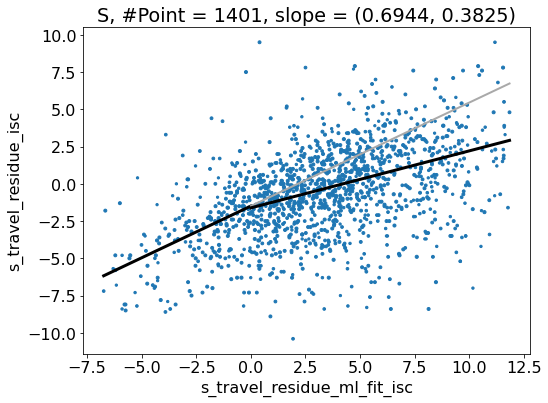

In [96]:
phase = 's'
x_option = f'{phase.lower()}_travel_residue_ml_fit_isc'
y_option = f'{phase.lower()}_travel_residue_isc'
substract_coef = 0#1/3.5
plot_slope(phase, x_option, y_option, substract_coef, year='*', min_snr=5, max_anomaly_abs=12, demean=False)

In [34]:
theilsen.score(x[x>=0].reshape(-1,1), y[x>=0])

-0.00757580308682182

In [71]:
df = pd.concat([pd.read_csv(filename) for filename in glob.glob(f'updeANMO_shift5_catalog_*_stnflt_isc_plot_s.csv')], ignore_index=True)
notnull = (df['s_travel_residue_isc'].notnull())
df.loc[df,'s_travel_residue_isc']
df.loc[(notnull) & (abs(df.loc[notnull,'s_travel_residue_isc'])>2), 's_travel_residue_isc']

1      -6.5
2       5.2
3       3.4
4       5.2
5       2.9
       ... 
2134   -7.9
2136   -2.7
2137    2.7
2140    2.7
2141   -2.1
Name: s_travel_residue_isc, Length: 722, dtype: float64

In [53]:
(df.iloc[2549]['s_travel_residue_isc']) 

False

count    26939.000000
mean         2.274576
std          1.983218
min         -7.376800
25%          1.041350
50%          2.028400
75%          3.149950
max         14.965400
Name: travel_time_residue_ml_fit_isc, dtype: float64


<AxesSubplot:>

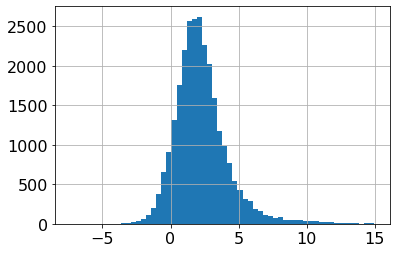

In [25]:
print(df.loc[df_xcorr,x_option].describe())
df.loc[df_xcorr,x_option].hist(bins=60)

count    26939.000000
mean         0.079702
std          1.114435
min         -5.100000
25%         -0.600000
50%          0.100000
75%          0.700000
max          7.000000
Name: travel_time_residue_isc, dtype: float64


<AxesSubplot:>

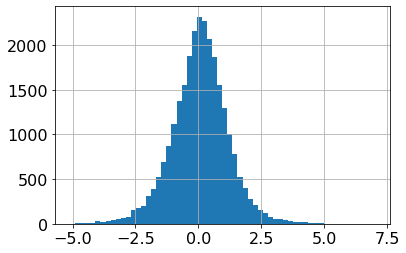

In [24]:
print(df.loc[df_xcorr,y_option].describe())
df.loc[df_xcorr,y_option].hist(bins=60)

In [25]:
max(df['anomaly_ak135'].values)

216.362

570 points fit the conditions
1560 points fit the conditions


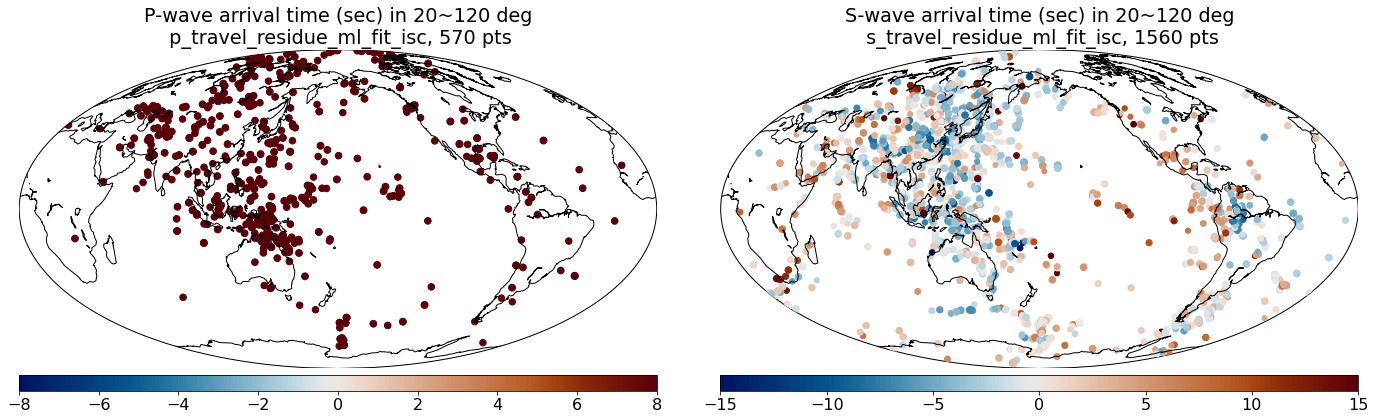

In [5]:
import glob
import numpy as np
import pandas as pd
from cmcrameri import cm
from obspy import UTCDateTime
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.figure(figsize=(24,8))
plt.rcParams["font.size"] = 16
map = Basemap(projection='moll',lon_0=-180,resolution='c')
map.drawmapboundary(fill_color='white')

def fidelity_rev(picker1_prob, picker1_anomaly, picker2_prob, picker2_anomaly): return picker1_prob - 0.7#0.72
def fidelity_rev_p(picker1_prob, picker1_anomaly, picker2_prob, picker2_anomaly): return picker1_prob - 0.9#0.75

def plot_depthslice(phase, value: str, gcarc_range: set, fidelity_func, org_constraint=lambda tb: pd.isnull(tb) | pd.notnull(tb), raw_prefix='updeANMO_shift_plot', ref_prefix=None, mark_size=lambda r: 50*r**2, year='*', max_anomaly_abs=15, min_probability=0.7, demean=False):
    table = pd.concat([pd.read_csv(filename) for filename in glob.glob(f'updeANMO_shift5_catalog_{year}_stnflt_isc_plot_{phase}.csv')], ignore_index=True)

    picker1_prob = table[f'{phase.lower()}_probability_ml']
    picker1_tres = table[value] #- np.mean(table[value].values[:]) if demean else 0
    picker2_prob = table[f'{phase.lower()}_probability_ml']
    picker2_tres = table[value] #- np.mean(table['travel_time_residue_isc'].values[:]) if demean else 0
    gcarc = table['gcarc_isc']
    prob = table[f'{phase.lower()}_probability_ml']

    fidelity = fidelity_func(picker1_prob=picker1_prob,
                             picker1_anomaly=picker1_tres,
                             picker2_prob=picker2_prob,
                             picker2_anomaly=picker2_tres)
    if value=='anomaly_org': fidelity = (fidelity+1)
    table_xcorr = (abs(table[value])<max_anomaly_abs) & (table[f'{phase.lower()}_probability_ml']>min_probability)

    # print(table[(org_constraint(table[value])) & (fidelity > 0) & (gcarc > gcarc_range[0]) & (gcarc < gcarc_range[1])])
    # scatter_table = table[(fidelity > 0) & (gcarc > gcarc_range[0]) & (gcarc < gcarc_range[1])]
    slice_contraint = (fidelity > 0) & (gcarc > gcarc_range[0]) & (gcarc < gcarc_range[1])
    if demean: table.loc[slice_contraint, value] -= np.nanmean(table.loc[slice_contraint, value])
    scatter_table = table[(org_constraint(table[value])) & slice_contraint]


    lons = scatter_table['turning_lon'].values[:]
    lats = scatter_table['turning_lat'].values[:]
    prob = scatter_table[picker1_prob.name].values[:]
    anomaly = scatter_table[value].values[:]
    # anomaly = UTCDateTime(scatter_table['arrival_time_ml'].values[:]) - UTCDateTime(scatter_table['origin_time_gcmt'].values[:])
    # anomaly = np.array([ UTCDateTime(arrival) - UTCDateTime(origin) for arrival, origin in zip(scatter_table['arrival_time_ml'].values[:], scatter_table['origin_time_gcmt'].values[:])])
    print(f"{sum(scatter_table[value].notnull())} points fit the conditions")
    # print(type(anomaly[0]))

    x, y = map(lons, lats)
    # if demean: anomaly -= np.nanmean(anomaly)

    map.drawmapboundary(fill_color='white')
    map.drawcoastlines()
    map.scatter(x, y, c=anomaly, s=mark_size(prob), marker='o', cmap=cm.vik)
    # map.scatter(x, y, c=anomaly, marker='o', cmap=cm.vik)
    map.colorbar(location='bottom')
    colorscale = 15 if phase.lower() == 's' else 8
    plt.clim(-colorscale, colorscale)
    plt.title(f'{phase.upper()}-wave arrival time (sec) in {gcarc_range[0]}~{gcarc_range[1]} deg\n {value}, {sum(scatter_table[value].notnull())} pts')

    return scatter_table

top_gcarc = 20
gcarc_interval = 100

plt.subplot(121)
# plot_depthslice('p', 'anomaly', (top_gcarc,top_gcarc+gcarc_interval), fidelity_rev_p, raw_prefix='updeANMO_shift5_catalog_*_stnflt_plot')
p_df = plot_depthslice('p', 'p_travel_residue_ml_fit_isc', (top_gcarc,top_gcarc+gcarc_interval), fidelity_rev_p, org_constraint=lambda tb: tb>10, raw_prefix='updeANMO_shift5_catalog_*_stnflt_isc_plot')
plt.subplot(122)
plot_depthslice('s', 's_travel_residue_ml_fit_isc', (top_gcarc,top_gcarc+gcarc_interval), fidelity_rev, raw_prefix='updeANMO_shift5_catalog_*_stnflt_isc_plot', demean=True)
# plot_depthslice('s', 'anomaly', (top_gcarc,top_gcarc+gcarc_interval), fidelity_rev, raw_prefix='updeANMO_shift5_catalog_*_stnflt_plot')
# plot_depthslice('s', 'anomaly', (90,110), fidelity_rev, raw_prefix='updeANMO_shift5_catalog_plot')
plt.subplots_adjust(wspace=0.1)
plt.show()

In [66]:
np.arange(-100,1500-100,0.25)

array([-100.  ,  -99.75,  -99.5 , ..., 1399.25, 1399.5 , 1399.75])

In [97]:
p_df.iloc

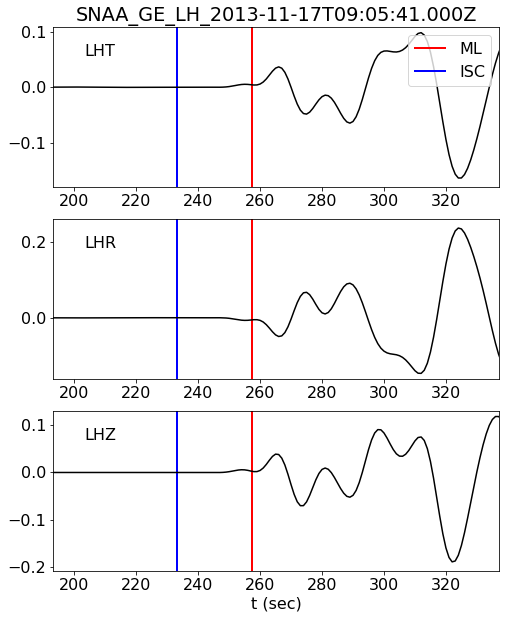

In [6]:
from obspy import read
# for record in p_df.iloc:
def plot_slow_p_waveform(record):
    t_origin = UTCDateTime(record.origin_time_gcmt)
    t_pick_ml = UTCDateTime(record.p_arrival_ml)
    t_pick_isc = UTCDateTime(record.p_arrival_isc)
    pick_ml = (t_pick_ml - t_origin)
    pick_isc = (t_pick_isc - t_origin)
    t = np.arange(-1800, 7200)
    xlim = (min(pick_ml, pick_isc)-40, max(pick_ml, pick_isc)+80)
    ylim_func = lambda data: (min(data[int(1800+xlim[0]):int(1800+xlim[1])])*1.1, max(data[int(1800+xlim[0]):int(1800+xlim[1])])*1.1)

    file_name_split = record.file_name.split('_')
    st = read(f"/Volumes/seismic/training_catalog_mass/{file_name_split[-1][:4]}/{file_name_split[-1]}/{file_name_split[1]}.{file_name_split[0]}.{file_name_split[2]}.obspy")
    plt.figure(figsize=(8,10))
    ax = plt.subplot(311)
    # print(len(st[0]))
    plt.vlines([pick_ml], -1, 1, color='r', linewidth=2)
    plt.vlines([pick_isc], -1, 1, color='b', linewidth=2)
    plt.plot(t, st[0].data, 'k')
    plt.xlim(xlim)
    plt.ylim(ylim_func(st[0].data))
    plt.legend(['ML', 'ISC'], loc='upper right')
    plt.text(min(pick_ml, pick_isc)-30, ylim_func(st[0].data)[0]+0.82*(ylim_func(st[0].data)[1]-ylim_func(st[0].data)[0]), st[0].stats.channel)
    plt.title(record.file_name)

    ax = plt.subplot(312)
    plt.vlines([pick_ml], -1, 1, color='r', linewidth=2)
    plt.vlines([pick_isc], -1, 1, color='b', linewidth=2)
    plt.plot(t, st[1].data, 'k')
    plt.xlim(xlim)
    plt.ylim(ylim_func(st[1].data))
    plt.text(min(pick_ml, pick_isc)-30, ylim_func(st[1].data)[0]+0.82*(ylim_func(st[1].data)[1]-ylim_func(st[1].data)[0]), st[1].stats.channel)

    ax = plt.subplot(313)
    plt.vlines([pick_ml], -1, 1, color='r', linewidth=2)
    plt.vlines([pick_isc], -1, 1, color='b', linewidth=2)
    plt.plot(t, st[2].data, 'k')
    plt.xlim(xlim)
    plt.ylim(ylim_func(st[2].data))
    plt.text(min(pick_ml, pick_isc)-30, ylim_func(st[2].data)[0]+0.82*(ylim_func(st[2].data)[1]-ylim_func(st[2].data)[0]), st[2].stats.channel)
    # ax.set_xlabel("My x label")
    # st.plot(fig=fig)
    # break

plot_slow_p_waveform(p_df.iloc[9])
plt.xlabel('t (sec)')
plt.show()

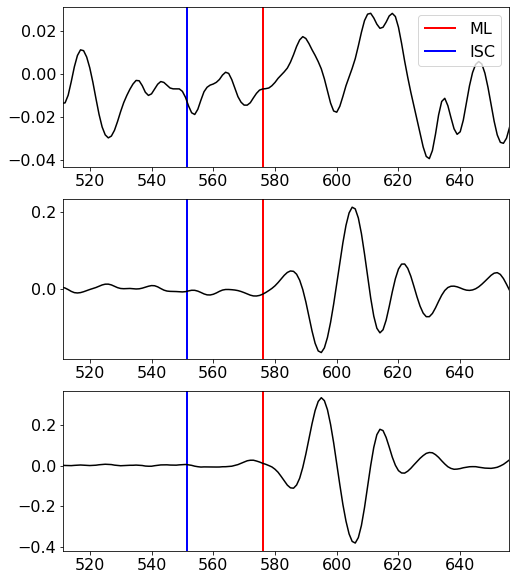

In [83]:
plot_slow_p_waveform(p_df.iloc[0])

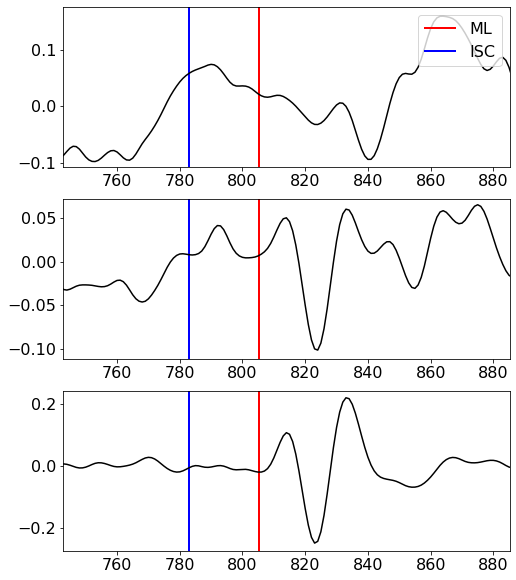

In [87]:
plot_slow_p_waveform(p_df.iloc[4])